In [18]:
import os
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Dataset class

In [19]:
class FireDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.image_paths = []
        self.labels = []

        for label, class_name in enumerate(self.classes):
            class_folder = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_folder):
                self.image_paths.append(os.path.join(class_folder, img_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [24]:
batch_size = 64
train_size = 0.7
val_size = 0.15
test_size = 0.15

dataset_path = "fire_dataset/"  
transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

fire_dataset = FireDataset(root_dir=dataset_path, transform=transform)
labels = np.array(fire_dataset.labels)


train_val_indices, test_indices = train_test_split(np.arange(len(fire_dataset)),test_size=test_size,stratify=labels)

val_relative_size = val_size / (train_size + val_size)
train_indices, val_indices = train_test_split(train_val_indices,test_size=val_relative_size,stratify=labels[train_val_indices])

train_subset = Subset(fire_dataset, train_indices)
val_subset = Subset(fire_dataset, val_indices)
test_subset = Subset(fire_dataset, test_indices)

print(f"Train subset size: {len(train_subset)}")
print(f"Validation subset size: {len(val_subset)}")
print(f"Test subset size: {len(test_subset)}")

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# Iterate through the dataloader
for images, labels in train_loader:
    print(f"Batch size: {images.size(0)}")
    print(f"Image shape: {images.size()}")
    print(f"Labels: {labels}")
    break

Train subset size: 10924
Validation subset size: 2342
Test subset size: 2342
Batch size: 64
Image shape: torch.Size([64, 3, 64, 64])
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0])


# Printing the first image and its label for fun


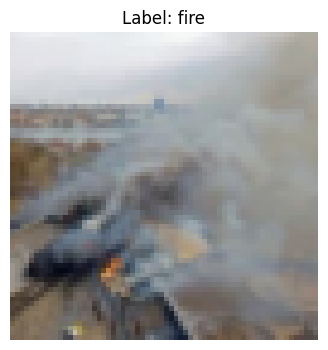

In [21]:
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # CxHxW to HxWxC
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip to [0, 1] range
    return img


classes = fire_dataset.classes

data_iter = iter(train_loader)
images, labels = next(data_iter)

img = imshow(images[0])
label = labels[0].item()

# Display the image with its label
plt.figure(figsize=(4,4))
plt.imshow(img)
plt.title(f"Label: {classes[label]}")
plt.axis('off')  # Hide axis
plt.show()

In [22]:
def extract_flattened_features(loader, max_batches=None):
    features = []
    labels = []
    batch_count = 0
    for images, lbls in loader:
        # Move images to CPU and convert to numpy
        images_np = images.numpy()
        # Flatten the images: (batch_size, channels, height, width) -> (batch_size, channels*height*width)
        batch_size, channels, height, width = images_np.shape
        images_flat = images_np.reshape(batch_size, -1)
        features.append(images_flat)
        labels.extend(lbls.numpy())
        batch_count += 1
        if max_batches is not None and batch_count >= max_batches:
            print(f"Processed {batch_count} batches.")
            break
    if features:
        features = np.vstack(features)
    else:
        features = np.array([])
    labels = np.array(labels)
    return features, labels

# Extract a limited number of features for testing
try:
    train_features, train_labels = extract_flattened_features(train_loader, max_batches=5)
    val_features, val_labels = extract_flattened_features(val_loader, max_batches=5)
    test_features, test_labels = extract_flattened_features(test_loader, max_batches=5)
    
    print(f"Train features shape (limited): {train_features.shape}")
    print(f"Validation features shape (limited): {val_features.shape}")
    print(f"Test features shape (limited): {test_features.shape}")
except Exception as e:
    print(f"An error occurred: {e}")

Processed 5 batches.
Processed 5 batches.
Processed 5 batches.
Train features shape (limited): (320, 12288)
Validation features shape (limited): (320, 12288)
Test features shape (limited): (320, 12288)


Data scaling complete.
PCA reduced dimensions to: 119


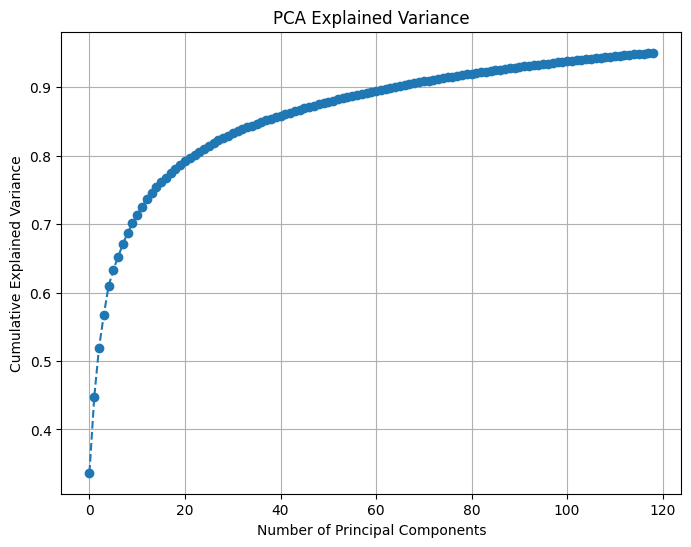

In [23]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform
train_scaled = scaler.fit_transform(train_features)

# Transform the validation and test data
val_scaled = scaler.transform(val_features)
test_scaled = scaler.transform(test_features)

print("Data scaling complete.")


# Initialize PCA to retain 95% of the variance
pca = PCA(n_components=0.95, whiten=False, random_state=42)

# Fit PCA on the training data and transform
train_pca = pca.fit_transform(train_scaled)

# Transform validation and test data
val_pca = pca.transform(val_scaled)
test_pca = pca.transform(test_scaled)

print(f"PCA reduced dimensions to: {train_pca.shape[1]}")

# Plot the cumulative explained variance to visualize how much variance is retained
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()